In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd

In [5]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
# Inspect the column names and types for measurement table
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# Inspect the column names and types for station table
inspector = inspect(engine)

columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

DatetimeIndex(['2016-08-23'], dtype='datetime64[ns]', freq=None)


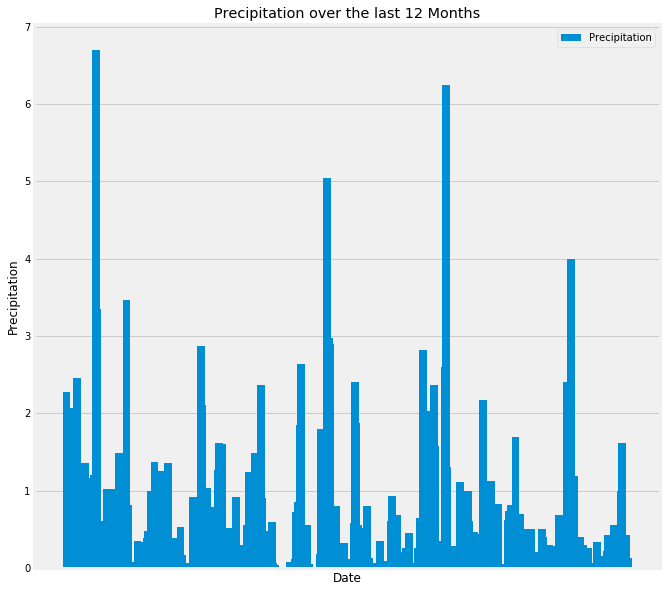

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

# Calculate the date 1 year ago from today, find the last record instead because data is not up to date
last_record= session.query(Measurement.date).order_by(Measurement.date.desc()).first()

twelve_months = pd.to_datetime(last_record) - dt.timedelta(days=365)
print (twelve_months)


# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > dt.date(2016,8,23)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['Date','Precipitation']).set_index("Date")
df = df.dropna(axis=0,how="all")
df = df.reset_index()

# Sort the dataframe by date
df.sort_values('Date')

# Create bar chart
x = df['Date']
height = df['Precipitation']

plt.figure(figsize=(10,10))
plt.bar(x, height, width = 5, label = "Precipitation")
plt.tick_params(labelbottom=False)
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.grid(axis = 'x')
plt.title("Precipitation over the last 12 Months")
plt.legend()
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# How many stations are available in this dataset?
stations = session.query(Station.station).count()
stations

9

In [17]:
# Using SQL Alchemy orm method, station and precipitation counts in descending order
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using SQL query method, station and precipitation counts in descending order
engine.execute('select station, COUNT(station) FROM measurement GROUP BY station ORDER BY COUNT(station) DESC').fetchall()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# What are the most active stations?
# List the stations and the counts in descending order.
# session.query('COUNT(date) FROM measurement GROUP BY station').all()
# session.query(func.count(Measurement.station)).(Measurement.station).all()
query = "SELECT station, COUNT(station) FROM measurement GROUP BY station ORDER BY COUNT(station) DESC"
df = pd.read_sql_query(query, session.bind)
df

,station,COUNT(station)
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [20]:
df.to_dict(orient='records')

[{'station': 'USC00519281', 'COUNT(station)': 2772},
 {'station': 'USC00519397', 'COUNT(station)': 2724},
 {'station': 'USC00513117', 'COUNT(station)': 2709},
 {'station': 'USC00519523', 'COUNT(station)': 2669},
 {'station': 'USC00516128', 'COUNT(station)': 2612},
 {'station': 'USC00514830', 'COUNT(station)': 2202},
 {'station': 'USC00511918', 'COUNT(station)': 1979},
 {'station': 'USC00517948', 'COUNT(station)': 1372},
 {'station': 'USC00518838', 'COUNT(station)': 511}]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

engine.execute("SELECT MIN(tobs), MAX(tobs), AVG(tobs) FROM measurement WHERE station = 'USC00519281'").fetchall()

[(54.0, 85.0, 71.66378066378067)]

In [22]:
# Choose the station with the highest number of temperature observations.
engine.execute("SELECT measurement.station, COUNT(measurement.tobs) FROM measurement GROUP BY station \
                ORDER BY COUNT(measurement.tobs) DESC").fetchall()
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# OR you can use the ORM method
results = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()



(array([ 10.,  17.,  66.,  85., 258., 246., 290., 591., 356., 283.,  18.,
          3.]),
 array([58.        , 60.41666667, 62.83333333, 65.25      , 67.66666667,
        70.08333333, 72.5       , 74.91666667, 77.33333333, 79.75      ,
        82.16666667, 84.58333333, 87.        ]),
 <a list of 12 Patch objects>)

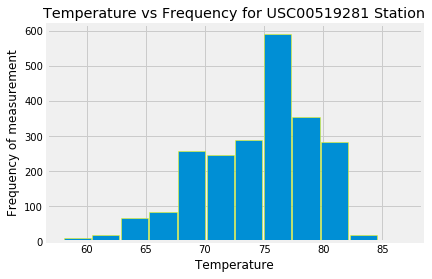

In [24]:
results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > dt.date(2016,8,23)).all()

tobs_df = pd.DataFrame(results, columns=['date','tobs'])


plt.title("Temperature vs Frequency for USC00519281 Station")
plt.xlabel('Temperature')
plt.ylabel('Frequency of measurement')
plt.hist(tobs_df['tobs'], bins=12, edgecolor='yellow', rwidth=0.95)



In [25]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

   
trip_temp = calc_temps('2016-8-23','2017-8-23')

temp_df = pd.DataFrame(trip_temp, columns=['Minimum Temperature','Average Temperature','Maximum Temperature'])
temp_df.head()

,Minimum Temperature,Average Temperature,Maximum Temperature
0,58.0,74.14388,87.0


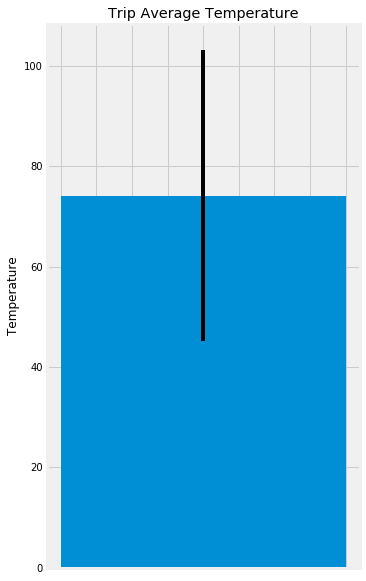

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(5,10))
plt.bar(x=0, height=temp_df['Average Temperature'], yerr=temp_df['Maximum Temperature']-temp_df['Minimum Temperature'])
plt.title('Trip Average Temperature')
plt.ylabel('Temperature')
plt.tick_params(labelbottom= False)
plt.show()


In [28]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

query = '''SELECT station.station, station.name, station.latitude, station.longitude, station.elevation, SUM(measurement.prcp)
    FROM station
    INNER JOIN measurement
    ON station.station=measurement.station
    WHERE date > '2016-8-23'
    GROUP BY station.station
    ORDER BY SUM(measurement.prcp) DESC'''

df = pd.read_sql_query(query, session.bind)
df

,station,name,latitude,longitude,elevation,SUM(measurement.prcp)
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,68.78
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,43.66
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,34.62
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,27.32
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,21.80
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,10.66
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,3.39


## Optional Challenge Assignment

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip

daily_normals("")
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


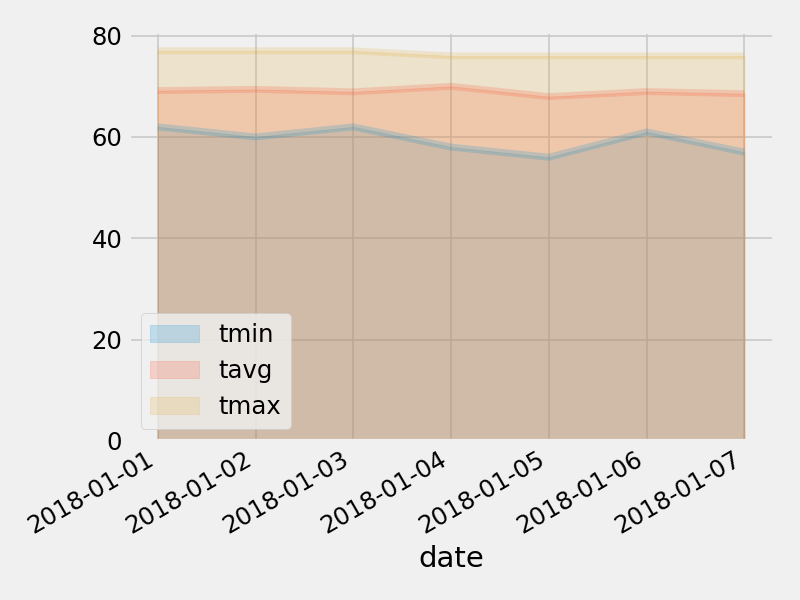

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
